In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Fri Jan 19 21:51:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   38C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.dalle_resblock_encoder import Encoder
from model.prior.rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.dalle_resblock_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 128
hp.hidden_dims = [256, 512]
hp.z_dim = 512
hp.n_prior_embeddings = 512
hp.init_log_sigma = -1
hp.const_sigma = True
hp.quantize = True

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 17.3046875
encoder.encoder 16.302734375
encoder.out_conv 1.001953125
prior 1.0
latent 3.814697265625e-06
quantizer 0.0
decoder 12.286144256591797
decoder.in_conv 1.001953125
decoder.decoder 11.284191131591797
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 2195, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader, Dataset
from data.imagenet_dataset import ImagenetDataset

train_data_dir = '/data/imagenet/val'
train_dataset = ImagenetDataset(root_dir=train_data_dir, img_size=hp.img_size)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

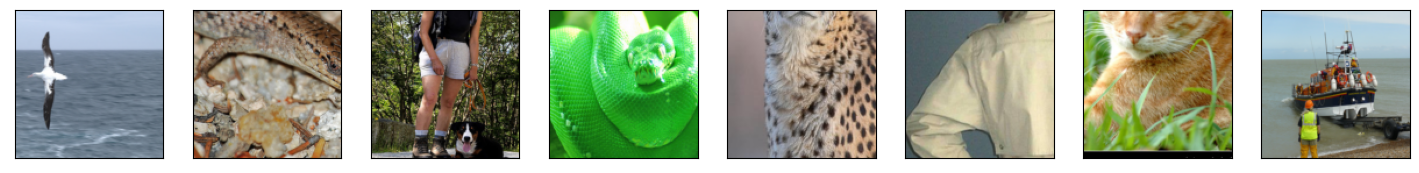

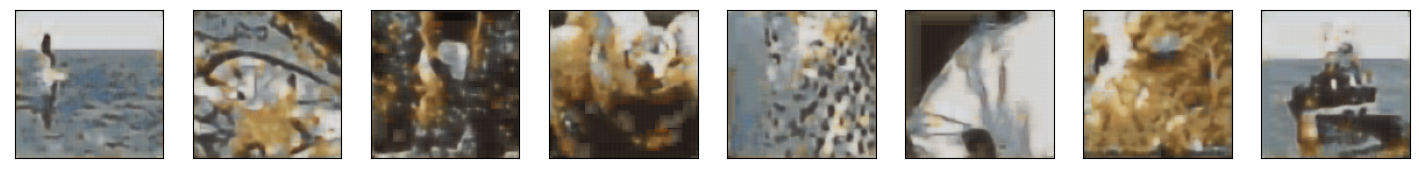

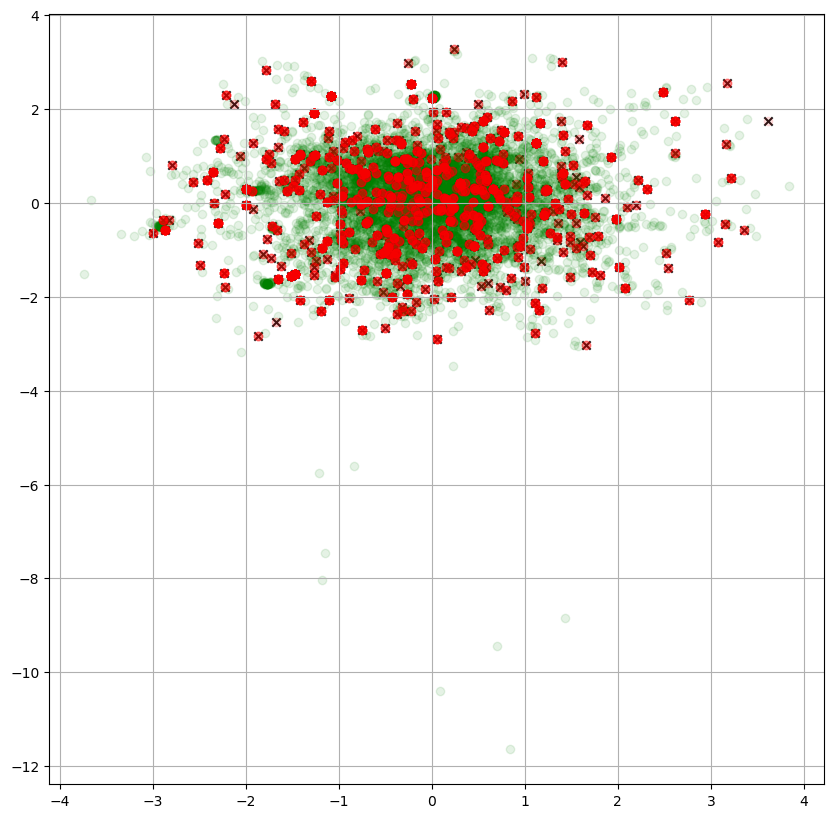

113001
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -743.6094360351562
recon_loss 0.012929469347000122
113002
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -741.5462036132812
recon_loss 0.0147788655012846
113003
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -744.542236328125
recon_loss 0.012821799144148827
113004
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -743.3782958984375
recon_loss 0.01675356924533844
113005
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -742.0320434570312
recon_loss 0.013458186760544777
113006
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -743.8975219726562
recon_loss 0.01294032484292984
113007
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -747.0331420898438
recon_loss 0.015774689614772797
113008
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -745.2572631835938
recon_loss 0.0113789988681674
113009


torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -740.980712890625
recon_loss 0.02010752633213997
113068
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -739.81103515625
recon_loss 0.015310483984649181
113069
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -744.7831420898438
recon_loss 0.016124654561281204
113070
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -744.5311279296875
recon_loss 0.009945772588253021
113071
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -745.4267578125
recon_loss 0.014312302693724632
113072
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -746.032958984375
recon_loss 0.025400206446647644
113073
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -732.9971923828125
recon_loss 0.01606987603008747
113074
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -744.5973510742188
recon_loss 0.010668931528925896
113075
torch.Siz

torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -741.7723388671875
recon_loss 0.011173464357852936
113137
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -745.5396118164062
recon_loss 0.011980419978499413
113138
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -744.3740234375
recon_loss 0.015092812478542328
113139
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -732.6309814453125
recon_loss 0.01276666484773159
113140
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -739.1023559570312
recon_loss 0.010271832346916199
113141
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -748.1809692382812
recon_loss 0.014096151106059551
113142
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -743.9115600585938
recon_loss 0.011213002726435661
113143
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -741.1395263671875
recon_loss 0.014723184518516064
113144
torc

torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -741.0089111328125
recon_loss 0.013603143393993378
113203
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -746.7403564453125
recon_loss 0.011470796540379524
113204
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -745.67626953125
recon_loss 0.015269957482814789
113205
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -737.68359375
recon_loss 0.012013599276542664
113206
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -746.7882080078125
recon_loss 0.009781702421605587
113207
torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])
lse_loss -747.0242919921875
recon_loss 0.014993253163993359
113208


In [ ]:
from IPython import display

min_indices = set()
while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 3*1000)
            data = model(data, quant_temp=quant_temp)
            min_indices.update(list(data['min_indices'].data.cpu().numpy()))

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
            plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
            plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
            plt.grid()
            plt.show() 
            
            usage = len(min_indices) / hp.n_prior_embeddings
            writer.add_scalar('usage', usage, step)
            min_indices = set()
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [14]:
data['x'].max()

tensor(1., device='cuda:0')